# Dogs vs. Cats

In [7]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [16]:
!pip install kaggle-cli
!kg config -g -u mivershov@gmail.com -p Aa1234567 -c dogs-vs-cats-redux-kernels-edition
!kg download

downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/test.zip

test.zip  32% |############                         | ETA:  0:00:04  39.0 MiB/s

test.zip 100% |#####################################| Time: 0:00:05  45.8 MiB/s

downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/train.zip

train.zip 100% |####################################| Time: 0:00:12  44.4 MiB/s

downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/sample_submission.csv

sample_submission.csv 100% |########################| Time: 0:00:00 408.9 KiB/s

/bin/sh: 1: 7z: not found


https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [21]:
!unzip test.zip
!unzip train.zip

^C
Archive:  train.zip
replace train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [8]:
!pip install keras

In [22]:
!ls

datalab  sample_submission.csv	test  test.zip	train  train.zip


In [0]:
import numpy as np
import keras
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import ModelCheckpoint

In [0]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

In [0]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

## Функции загрузки данных

In [0]:
import re
from random import shuffle
from glob import glob

train_files = glob('./train/*.jpg')
test_files = glob('./test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для ResNet50

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=4):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

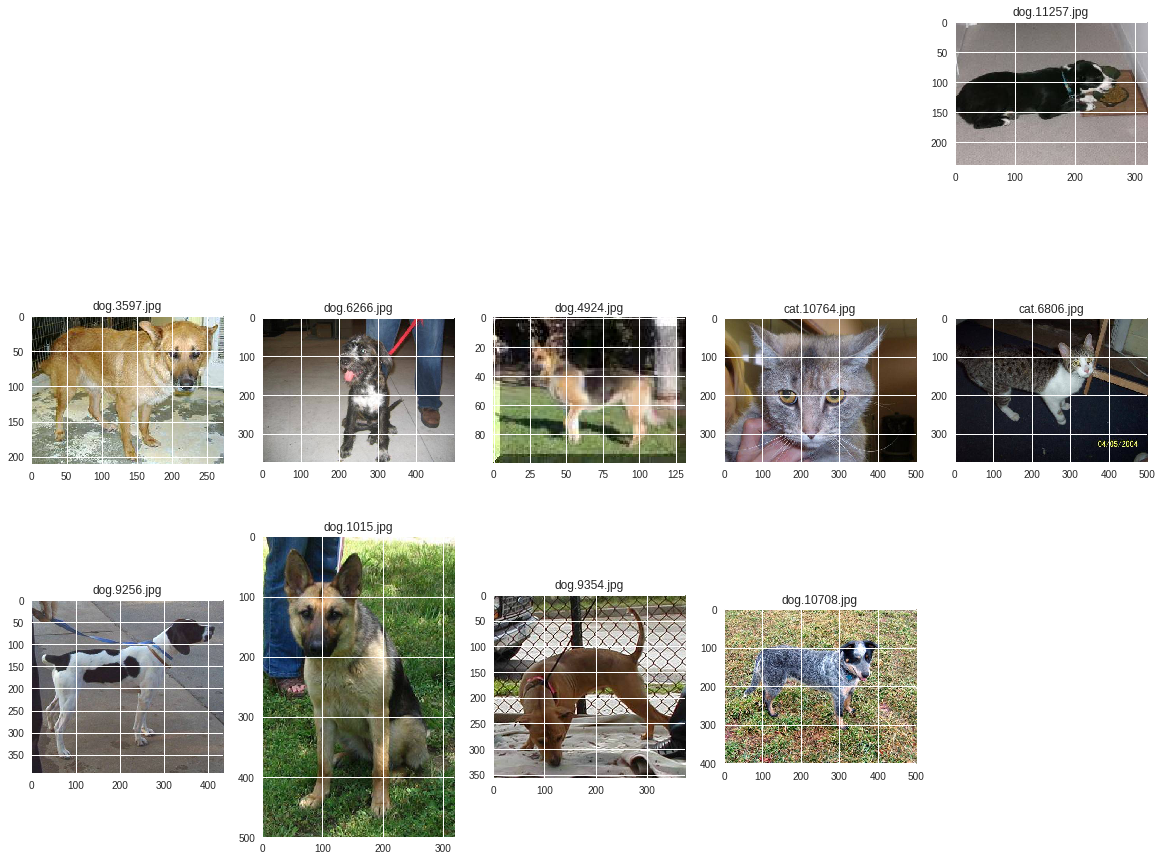

In [32]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

In [33]:
len(train_files)

25000

## Загружаем предобученную модель

In [0]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = ResNet50(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [0]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

In [49]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

## Добавляем полносвязный слой

In [50]:
base_model.layers[-2].name

'activation_98'

In [0]:
x = base_model.layers[-1].output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1,  # один выход
                activation='sigmoid',  # функция активации  
                kernel_regularizer=keras.regularizers.l1(1e-4))(x)
model = Model(inputs=base_model.input, outputs=x)

## Выводим архитектуру модели

In [52]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

## Компилируем модель и запускаем обучение

In [0]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [0]:
filepath="weights-improvement-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [58]:
%%time
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=25,  # число эпох обучения
        verbose=1,
        callbacks=callbacks_list,
        validation_data=validation_data)

Epoch 1/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.1523 - acc: 0.9722
Epoch 00001: val_loss did not improve
10/10 [==============================] - 2s 239ms/step - loss: 0.1386 - acc: 0.9750 - val_loss: 0.0715 - val_acc: 0.9600
Epoch 2/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.1896 - acc: 0.9444
Epoch 00002: val_loss did not improve
10/10 [==============================] - 2s 232ms/step - loss: 0.2046 - acc: 0.9250 - val_loss: 0.0669 - val_acc: 0.9900
Epoch 3/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.3314 - acc: 0.8889
Epoch 00003: val_loss did not improve
10/10 [==============================] - 2s 232ms/step - loss: 0.3064 - acc: 0.9000 - val_loss: 0.1189 - val_acc: 0.9600
Epoch 4/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.2261 - acc: 0.9167
Epoch 00004: val_loss did not improve
10/10 [==============================] - 2s 230ms/step - loss: 0.2404 - acc: 0.9000 - val_loss: 0.0946 - val_acc: 0.9700
Epoch 5/

Epoch 10/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0974 - acc: 1.0000
Epoch 00010: val_loss did not improve
10/10 [==============================] - 2s 233ms/step - loss: 0.0912 - acc: 1.0000 - val_loss: 0.0741 - val_acc: 0.9700
Epoch 11/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.2963 - acc: 0.8889
Epoch 00011: val_loss did not improve
10/10 [==============================] - 2s 232ms/step - loss: 0.2789 - acc: 0.9000 - val_loss: 0.1459 - val_acc: 0.9500
Epoch 12/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0729 - acc: 0.9722
Epoch 00012: val_loss did not improve
10/10 [==============================] - 2s 233ms/step - loss: 0.0790 - acc: 0.9750 - val_loss: 0.1193 - val_acc: 0.9700
Epoch 13/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.2292 - acc: 0.9167
Epoch 00013: val_loss did not improve
10/10 [==============================] - 2s 233ms/step - loss: 0.2088 - acc: 0.9250 - val_loss: 0.0948 - val_acc: 0.9700
Epoc


Epoch 00018: val_loss did not improve
10/10 [==============================] - 2s 233ms/step - loss: 0.2460 - acc: 0.8750 - val_loss: 0.0524 - val_acc: 0.9900
Epoch 19/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.3014 - acc: 0.8611
Epoch 00019: val_loss did not improve
10/10 [==============================] - 2s 231ms/step - loss: 0.2750 - acc: 0.8750 - val_loss: 0.0914 - val_acc: 0.9700
Epoch 20/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.2079 - acc: 0.9167
Epoch 00020: val_loss did not improve
10/10 [==============================] - 2s 231ms/step - loss: 0.2935 - acc: 0.9000 - val_loss: 0.0853 - val_acc: 0.9700
Epoch 21/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.1239 - acc: 1.0000
Epoch 00021: val_loss did not improve
10/10 [==============================] - 2s 228ms/step - loss: 0.1417 - acc: 0.9750 - val_loss: 0.0824 - val_acc: 0.9700
Epoch 22/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.2307 - acc: 0.9167
Epo

In [0]:
#!ls
model.load_weights('weights-improvement-24-0.0330.hdf5')

## Предсказания на проверочной выборке

In [61]:
%%time
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

CPU times: user 3min 29s, sys: 15.8 s, total: 3min 45s
Wall time: 6min 34s


In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

## Готовим данные для сабмита

In [0]:
with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

In [0]:
from google.colab import files
files.download('submit.txt')

In [0]:
# LogLoss = 0.08370